The adventure stemmed from a case presented by the wonderful Nick Berry in [his DataGenetics blog](https://datagenetics.com/blog/march22021/index.html):

## Six Switch Puzzle
### The Question
In summary, there are six switches numbered from 1 to 6, with each one being connected to a lamp. You roll a regular die, and toggle the switch corresponding to the roll result (if it was OFF -> ON; if it was ON -> OFF). Starting with the state where all the switches are OFF, how many, on the average, rolls are needed to lit all the lights?

### Analytical Solution
(taken almost directly from  [Nick Berry's DataGenetics blog](https://datagenetics.com/blog/march22021/index.html) with some simple explanations added)

If there are currently $n$ lit LEDs, the probability of rolling one of these lit LED is just $\tfrac{n}{6}$, the probability of rolling an unlit LED is $\tfrac{6-n}{n}$:

$$n\rightarrow\left\{\begin{array}{l} n+1,\;(Pr=\tfrac{6-n}{6}) \\  n-1,\;(Pr=\tfrac{n}{6}) \end{array}\right.$$

Define $R_n$ to represent the number of expected moves to complete the game from the state where there are currently $n$ lit LEDs on the machine.

For example, If there are five LEDs lit, there is a 1/6 chance of rolling the missing switch (this will take one roll), or there is a 5/6 chance of hitting an already lit light (which will also burn one roll, and then place us back to the state $R_4$):

$$R_5 = \frac{1}{6}[1] + \frac{5}{6}[1+R_4]$$

So, if we find ourselves where 5 LEDs are lit and if it took us $a$ moves on the average to get here, we will add a 1/6 move to the average if we manage to complete the challenge.

Moving on to 4 lit LED situation, there are two chances in six that we'll advance (take on roll and transfer us to state $R_5$), and four chances in six that we'll take on roll and end up back at state $R_3$:

$$R_4 = \frac{2}{6}[1+R_5] + \frac{4}{6}[1+R_3]$$

continuing on, we have:

$$R_3 = \frac{3}{6}[1+R_4] + \frac{3}{6}[1+R_2]$$

$$R_2 = \frac{4}{6}[1+R_3] + \frac{2}{6}[1+R_1]$$

$$R_1 = \frac{5}{6}[1+R_2] + \frac{1}{6}[1+R_0]$$

Finally, when game starts, all switches are initially OFF ($R_0$), and it’s a sure thing that we’ll take one roll and end up in state $R_1$ (the expected number of moves is one plus the expected number of moves to complete with the state with one LED lit).

$$R_0 = \frac{6}{6}[1+R_1]$$

So we have 6 equations with 6 unknowns - let's solve them:

In [1]:
import numpy as np
A = []
b = []
A.append([0, 0, 0, 0, -5/6, 1]) # R5 = ...
A.append([0, 0, 0, -4/6, 1, -2/6]) # R4 = ...
A.append([0, 0, -3/6, 1, -3/6, 0]) # R3 = ...
A.append([0, -2/6, 1, -4/6, 0, 0]) # R2 = ...
A.append([-1/6, 1, -5/6, 0, 0, 0]) # R1 = ...
A.append([1, -6/6, 0, 0, 0, 0]) # R0 = ...
b.append(1/6 + 5/6)
b.append(2/6 + 4/6)
b.append(3/6 + 3/6)
b.append(4/6 + 2/6)
b.append(5/6 + 1/6)
b.append(6/6)

R = np.linalg.solve(A,b)
for i in range(len(R)):
    print("R{:d}: {:.4f}".format(i,R[i]))

R0: 83.2000
R1: 82.2000
R2: 80.8000
R3: 78.6000
R4: 74.4000
R5: 63.0000


Average number of steps it takes to turn on all the LEDs: 83.2 (analytically)

## Monte Carlo Approach
After encountering this intriguing puzzle, I decided to solve this via Monte Carlo approach:

1. Start from all the switches OFF state.
2. Roll die until all of them are ON, count the number of tries it took to get there, write it down.
3. Restart from step 1 many times
4. Take the average of the recorded number of tries.

Here we go:

In [2]:
import numpy as np
import random

def one_run():
    counter = 0
    switches = np.full((6), False)
    #print(switches)
    while not np.all(switches):
        randi = random.randint(0,5)
        switches[randi] = not switches[randi]
        counter += 1
    #print(switches)
    return counter

In [3]:
one_run()

20

In [4]:
import time

#N = 1000000
N = 10000
tries = []

start = time.perf_counter()
for i in range(N):
    tries.append(one_run())
finish = time.perf_counter()
print("\nFinished in {:.2f} seconds.".format(finish-start))

tries = np.array(tries)
mean = tries.mean()
print("Average number of rolls to get all-ON: {:.3f}".\
      format(mean))


Finished in 3.03 seconds.
Average number of rolls to get all-ON: 82.882


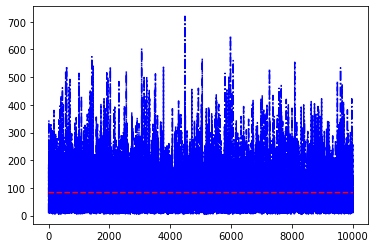

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(N),tries,"-.b")
plt.plot(range(N),np.ones(N)*mean,"--r")
plt.show()

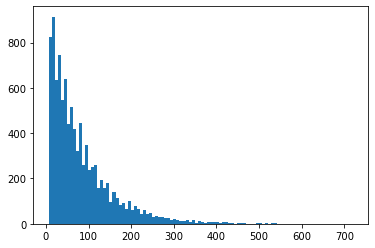

In [6]:
plt.hist(tries,bins=100)
plt.show()

There is a very nice but expensive way of seeing the fluctuation (and eventually settling(/convergence) of the mean as the number of tries increases): by re-calculating the mean at each roll which goes something like this:

```python
# I'm including this part as raw code as 
# I don't want anybody to run it unaware...

import time
means = []
start = time.perf_counter()
for i in range(N):
    means.append(tries[0:i+1].mean())
finish = time.perf_counter()

print("\nFinished in {:.2f} seconds.".format(finish-start))
# Finished in 286.60 seconds.
```

Doing the job like this for $N=1000000$ took about 5 minutes on my computer. Before we dived right into it, we could have used our brains and instead of re-calculating the mean by starting from scratch every time, we could just use the average calculated in the previous iteration:

In [7]:
import time
means = [tries[0]]
n = 1
start = time.perf_counter()
for i in range(1,N):
    this_mean = i*means[i-1]/(i+1) + tries[i]/(i+1)
    means.append(this_mean)
#print (means[-1])
finish = time.perf_counter()

print("\nFinished in {:.2f} seconds.".format(finish-start))


Finished in 0.01 seconds.


This takes about 1 second as opposed to the 5 minutes of the direct approach.

So, let's plot the plot once again, this time along with the mean calculated up to that # of tries:

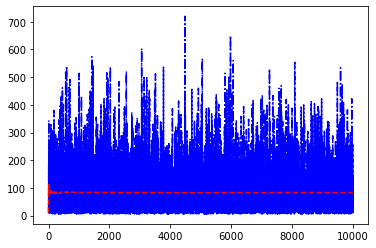

In [8]:
plt.plot(range(N),tries,"-.b")
plt.plot(range(N),means,"--r")
plt.show()

Zooming in, we have:

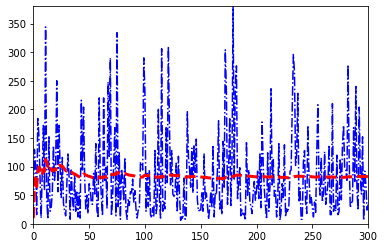

In [9]:
plt.plot(range(N),tries,"-.b")
plt.plot(range(N),means,"--r",linewidth=3.0)
plt.xlim(0,300)
plt.ylim(0,np.max(tries[0:300]))
plt.show()

So, it seems that, it settles to the expected value pretty fast.